In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
import joblib
import shap
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

# HYPOTHESIS TESTING
from scipy.stats import ks_2samp, normaltest, boxcox, yeojohnson, shapiro
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Sklearn preprocessing
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor,StackingRegressor,RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.kernel_approximation import Nystroem


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 42

In [159]:
# Load data
train = pd.read_csv('data/train.csv',index_col=0)
test = pd.read_csv('data/test.csv',index_col=0)
sub = pd.read_csv('data/sample_submission.csv',index_col=0)

# Understanding Abalone Dataset Features

- Sex: This feature represents the gender of the abalone,categorized as male (M), female (F), or infant (I).

- Length: The length feature denotes the longest measurement of the abalone shell, from the apex to the base, measured in millimeters.

- Diameter: Diameter represents the measurement of the abalone shell perpendicular to its length, also measured in millimeters.

- Height: This feature signifies the height of the abalone shell, measured perpendicular to the plane formed by the length and diameter, in millimeters.

- Whole weight: Whole weight indicates the total weight of the abalone, encompassing both the meat and the shell, measured in grams.

- Whole weight.1 (Shucked weight): This feature represents the weight of the abalone meat only, measured in grams. It indicates the amount of meat extracted from the shell.

- Whole weight.2 (Viscera weight): Viscera weight signifies the weight of the abalone gut after bleeding, measured in grams.It provides insights into the weight of the internal organs of the abalone.

- Shell weight: This feature represents the weight of the abalone shell only, excluding the meat, measured in grams. It provides insights into the weight distribution between the shell and the edible portion of the abalone.

- Rings: Rings signify the number of rings present on the abalone shell, serving as an indicator of the abalone's age.

In [160]:
def rename_and_lowercase(df):
    """Rename columns and convert them to lowercase"""
    df = df.rename(columns = {'Whole weight.1':'shucked weight'})
    df = df.rename(columns = {'Whole weight.2':'viscera weight'})
    df = df.rename(columns=lambda x: x.lower().replace(' ', '_'))
    return df

train = rename_and_lowercase(train)
test = rename_and_lowercase(test)

train.columns, test.columns

(Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'rings'],
       dtype='object'),
 Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight'],
       dtype='object'))

# 1 - EDA - Exploratory Analysis

## 1.1 - Summary Statistics

In [161]:
def generate_summary_statistics(data):
  
    summary_table = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summary_table['Missing'] = data.isnull().sum()
    summary_table['Unique'] = data.nunique()
    summary_table['Count'] = data.count()
    summary_table['Duplicated'] = data.duplicated().sum()
    summary_table['zero_values'] = data.isin([0]).sum()
    
    
    return summary_table

In [162]:
generate_summary_statistics(train)

,dtypes,Missing,Unique,Count,Duplicated,zero_values
sex,object,0,3,90615,0,0
length,float64,0,157,90615,0,0
diameter,float64,0,126,90615,0,0
height,float64,0,90,90615,0,6
whole_weight,float64,0,3175,90615,0,0
shucked_weight,float64,0,1799,90615,0,0
viscera_weight,float64,0,979,90615,0,0
shell_weight,float64,0,1129,90615,0,0
rings,int64,0,28,90615,0,0


In [163]:
generate_summary_statistics(test)

,dtypes,Missing,Unique,Count,Duplicated,zero_values
sex,object,0,3,60411,0,0
length,float64,0,148,60411,0,0
diameter,float64,0,130,60411,0,0
height,float64,0,85,60411,0,2
whole_weight,float64,0,3037,60411,0,0
shucked_weight,float64,0,1747,60411,0,0
viscera_weight,float64,0,960,60411,0,0
shell_weight,float64,0,1089,60411,0,0


<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
    <h2>Summary statistics</h2>
    <p>There are missing values in the dataset. The column <b>height</b> .</p>
<div>

## 1.2 - Univariate Analysis

In [164]:
# function to calculate univariate stats like pandas describe method
def univariate_stats(df):
    
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]
    
    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)

In [165]:
univariate_stats(train)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
whole_weight,90615,0,3175,float64,True,0.5805,0.789035,0.002,0.419,0.7995,1.0675,2.8255,0.457671,0.429316,-0.185136
shucked_weight,90615,0,1799,float64,True,0.096,0.340778,0.001,0.1775,0.33,0.463,1.488,0.204428,0.591973,0.284012
shell_weight,90615,0,1129,float64,True,0.24,0.225898,0.0015,0.12,0.225,0.305,1.005,0.130203,0.479092,0.096049
viscera_weight,90615,0,979,float64,True,0.1715,0.169422,0.0005,0.0865,0.166,0.2325,0.76,0.100909,0.476733,-0.203721
length,90615,0,157,float64,True,0.575,0.517098,0.075,0.445,0.545,0.6,0.815,0.118217,-0.732015,0.133364
diameter,90615,0,126,float64,True,0.45,0.401679,0.055,0.345,0.425,0.47,0.65,0.098026,-0.695236,0.000646
height,90615,0,90,float64,True,0.15,0.135464,0.0,0.11,0.14,0.16,1.13,0.038008,0.309975,13.454051
rings,90615,0,28,int64,True,9,9.696794,1,8.0,9.0,11.0,29,3.176221,1.204273,2.612934
sex,90615,0,3,object,False,I,-,-,-,-,-,-,-,-,-


**Note** : height has some null values

In [166]:
univariate_stats(test)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
whole_weight,60411,0,3037,float64,True,0.5805,0.790062,0.002,0.4195,0.8015,1.07,2.8255,0.457591,0.435664,-0.165426
shucked_weight,60411,0,1747,float64,True,0.3485,0.341227,0.001,0.1785,0.329,0.4645,1.488,0.204221,0.593206,0.290172
shell_weight,60411,0,1089,float64,True,0.24,0.226125,0.0015,0.12,0.225,0.305,1.004,0.129826,0.468524,0.042671
viscera_weight,60411,0,960,float64,True,0.1715,0.169419,0.0005,0.0865,0.166,0.2325,0.6415,0.10072,0.476129,-0.204883
length,60411,0,148,float64,True,0.575,0.517428,0.075,0.45,0.545,0.6,0.8,0.117609,-0.734565,0.141789
diameter,60411,0,130,float64,True,0.45,0.401961,0.055,0.345,0.425,0.47,0.65,0.09747,-0.696312,0.004065
height,60411,0,85,float64,True,0.15,0.135751,0.0,0.11,0.14,0.16,1.095,0.038175,0.554506,17.693333
sex,60411,0,3,object,False,I,-,-,-,-,-,-,-,-,-


In [167]:
# list of numerical and categorical columns

numeric_cols = train.select_dtypes(exclude=['object']).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
target = 'rings'
numeric_cols_without_target = [col for col in numeric_cols if col != target]

numeric_cols, categorical_cols, numeric_cols_without_target

(['length',
  'diameter',
  'height',
  'whole_weight',
  'shucked_weight',
  'viscera_weight',
  'shell_weight',
  'rings'],
 ['sex'],
 ['length',
  'diameter',
  'height',
  'whole_weight',
  'shucked_weight',
  'viscera_weight',
  'shell_weight'])

### Histograms

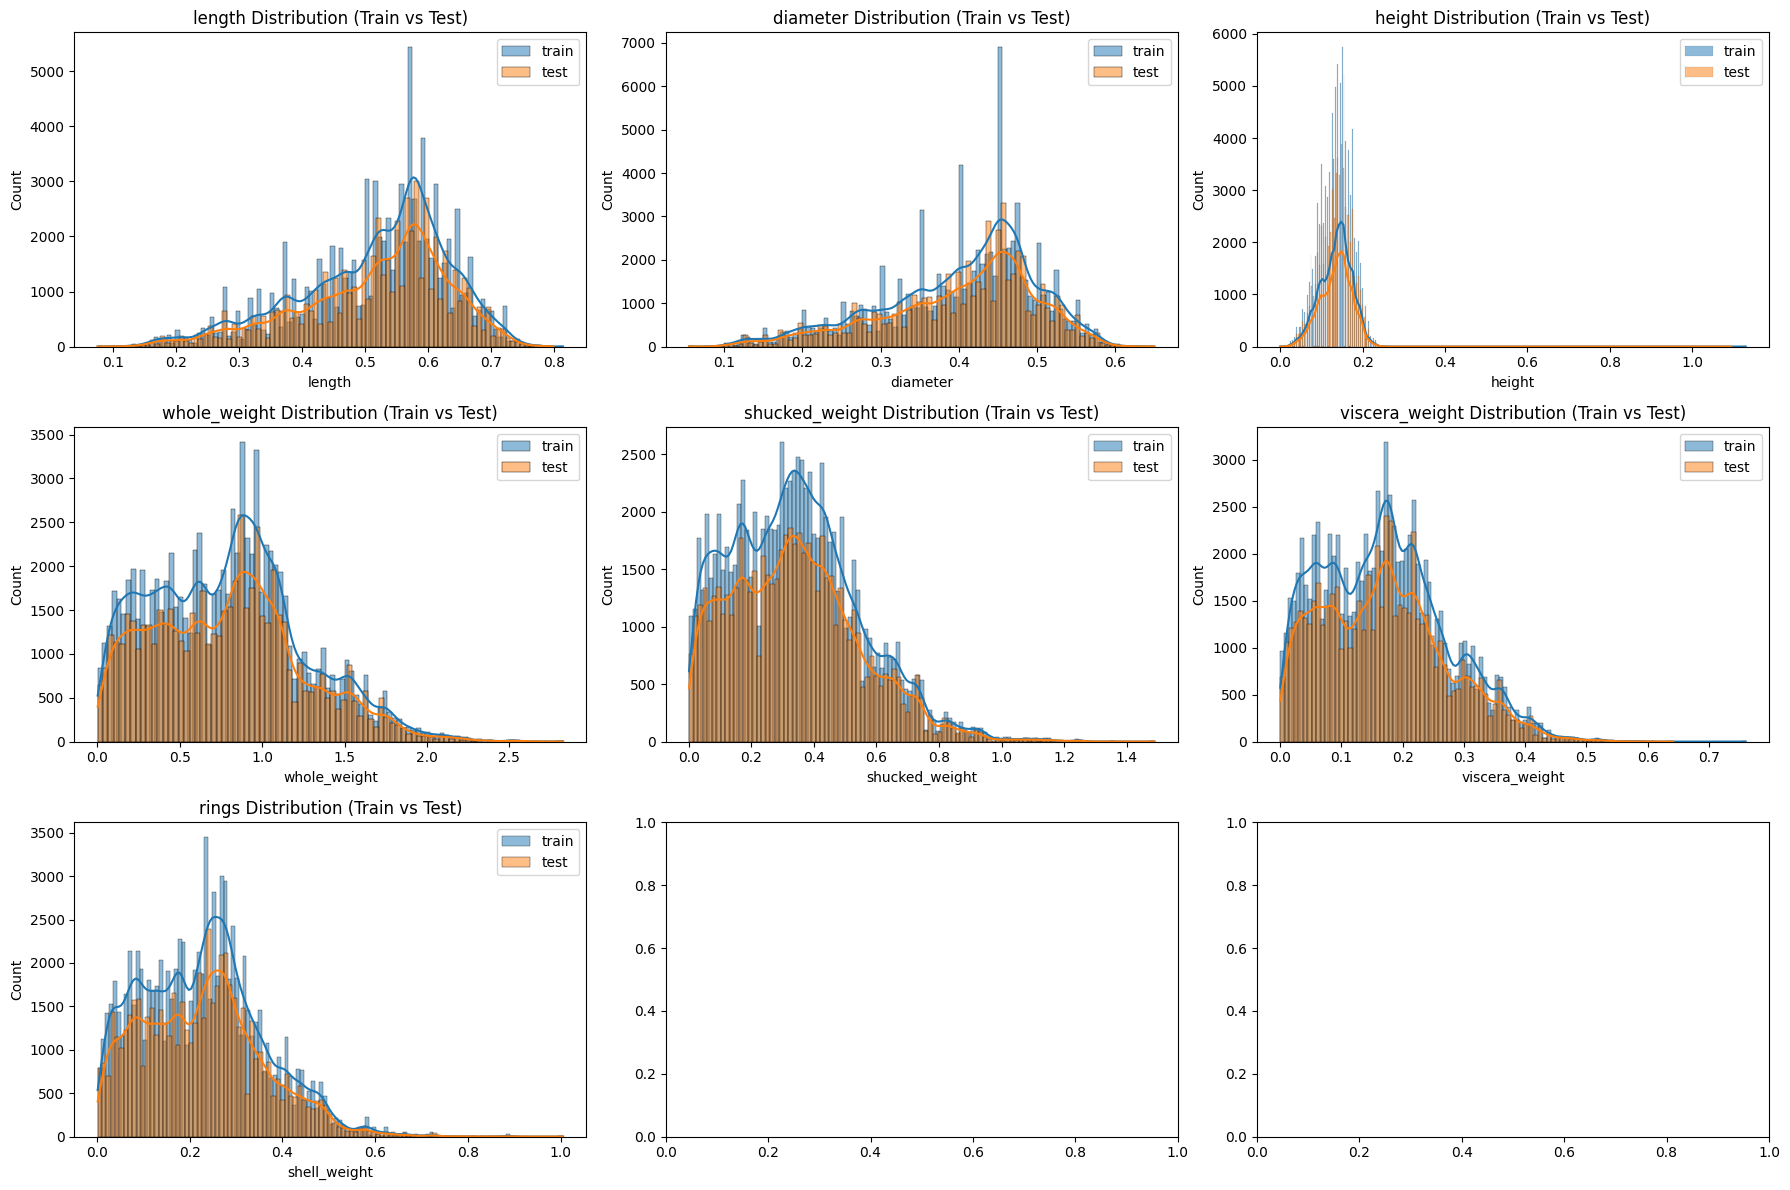

In [168]:
def plot_histograms(df_train, df_test, target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))

    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        
        if var_name != target_col:
            ax = axes[i]
       
            # plot histogram for each variable in train
            sns.histplot(df_train[var_name], kde=True, ax=ax, label='train')

            # plot histogram for each variable in test
            sns.histplot(df_test[var_name], kde=True, ax=ax, label='test')

        
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_histograms(train[numeric_cols], test, target, n_cols=3)

### Distributions

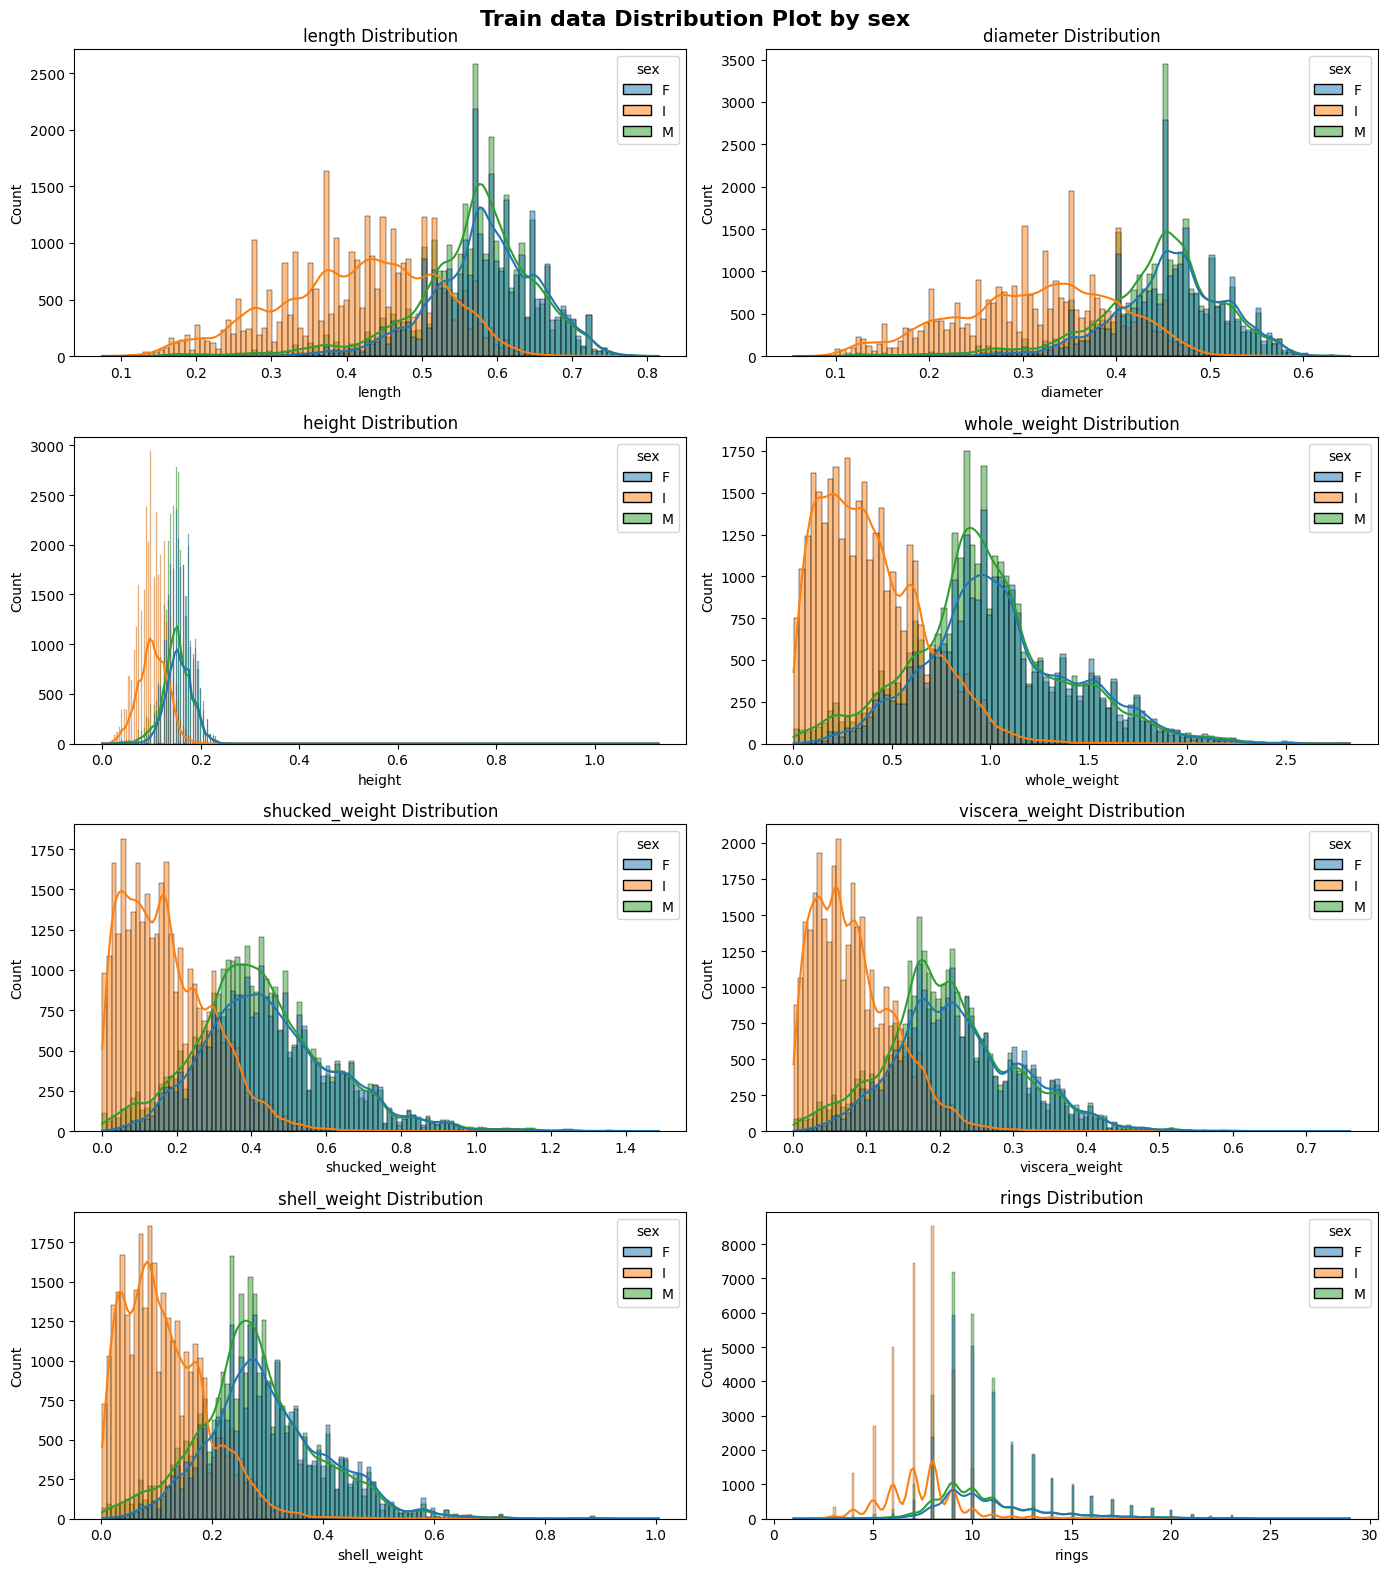

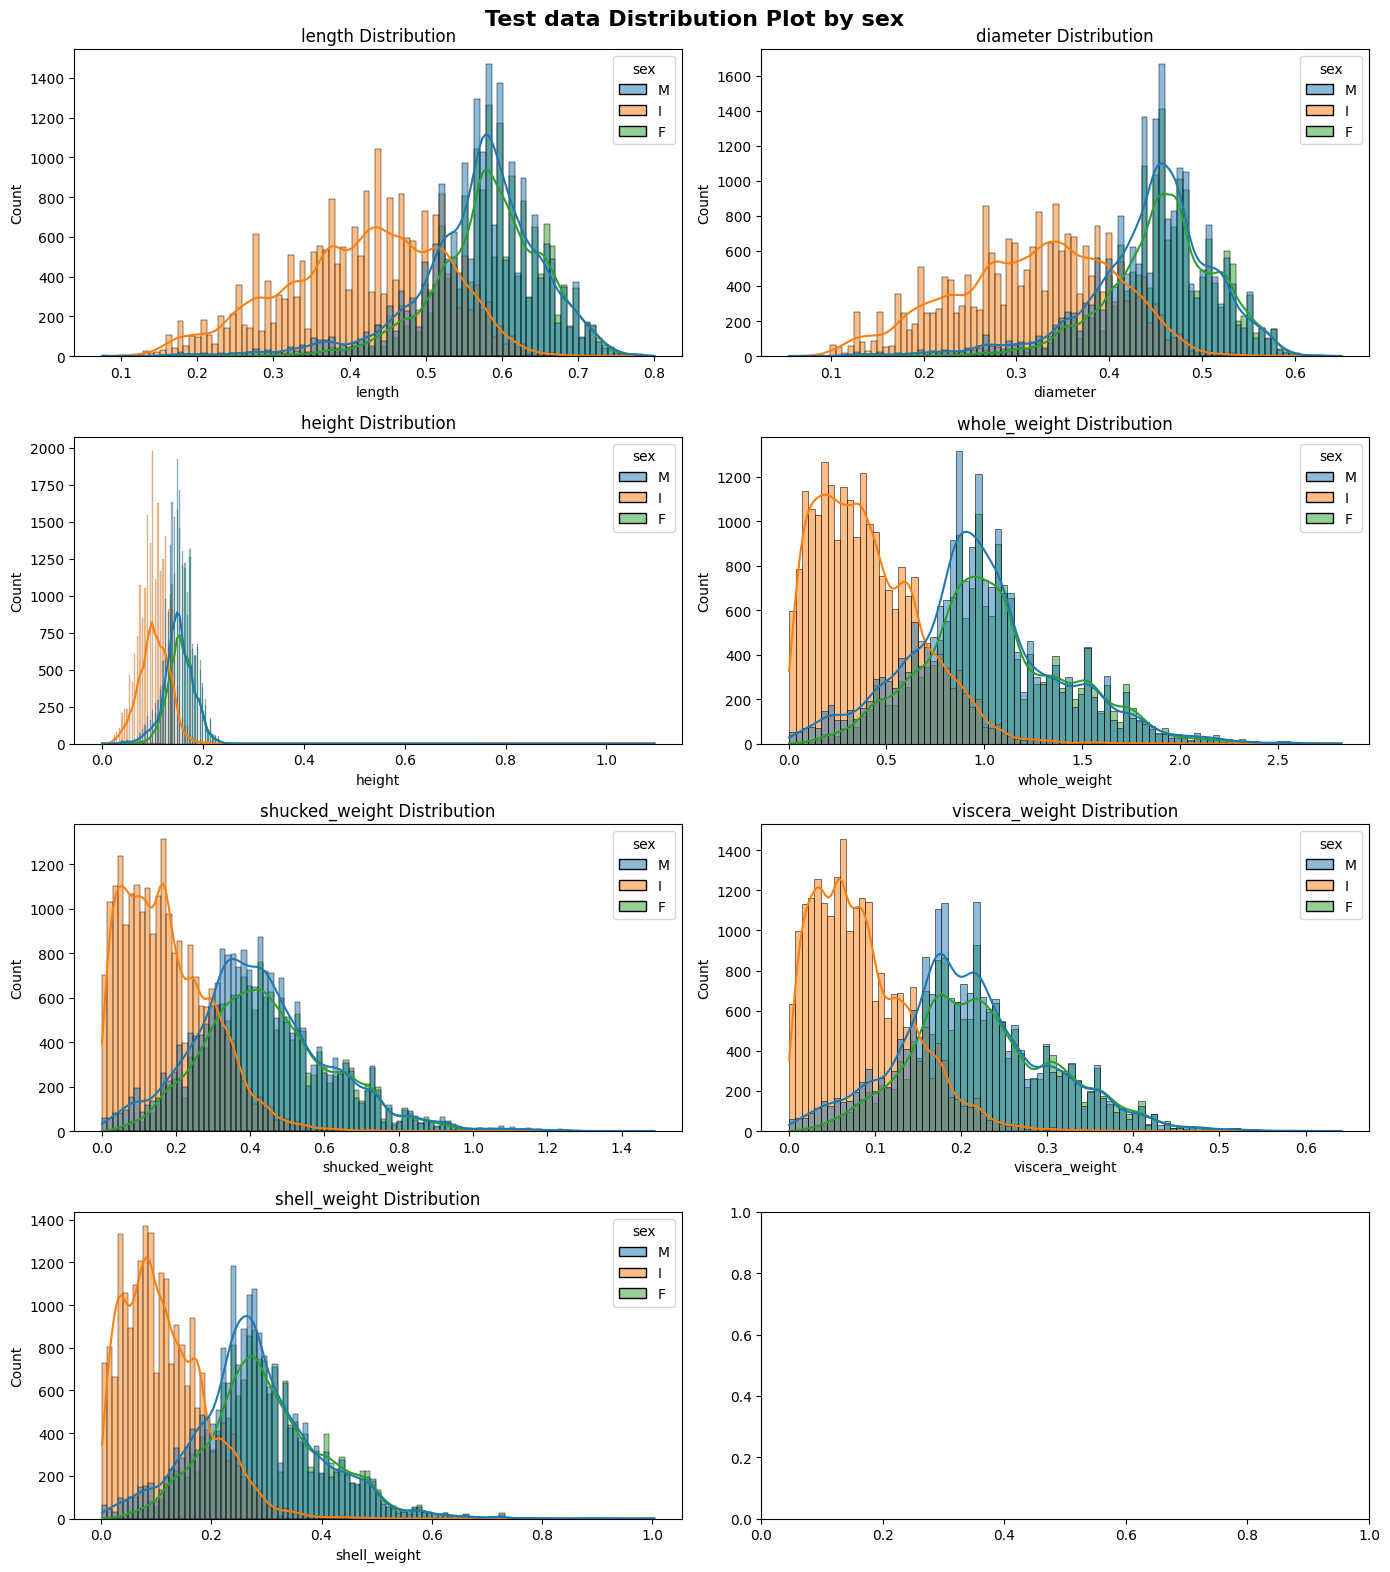

In [169]:
def plot_distributions(df, hue, title='', drop_cols=[]):
    
    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    
    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]
        sns.histplot(df, x=var_name, hue=hue, kde=True, ax=ax)
        ax.set_title(f'{var_name} Distribution')
    
    fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_distributions(train,hue='sex', title='Train data')
plot_distributions(test,hue='sex', title='Test data')
    

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
    
**Note:** 
<ul>
    <li>There is a big difference in distribution between I (infant) and adults (M or F). It almost like a binary variable, either is is infant or not</li>
    <li>Maybe test it feature engineering</li>
</ul>

</div>

### Correlations

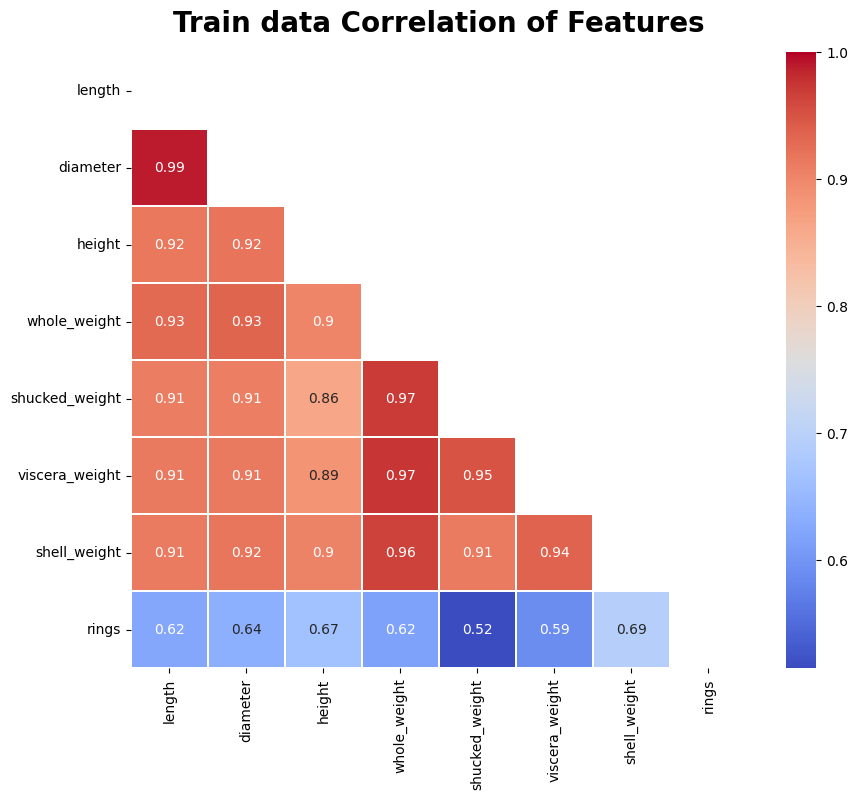

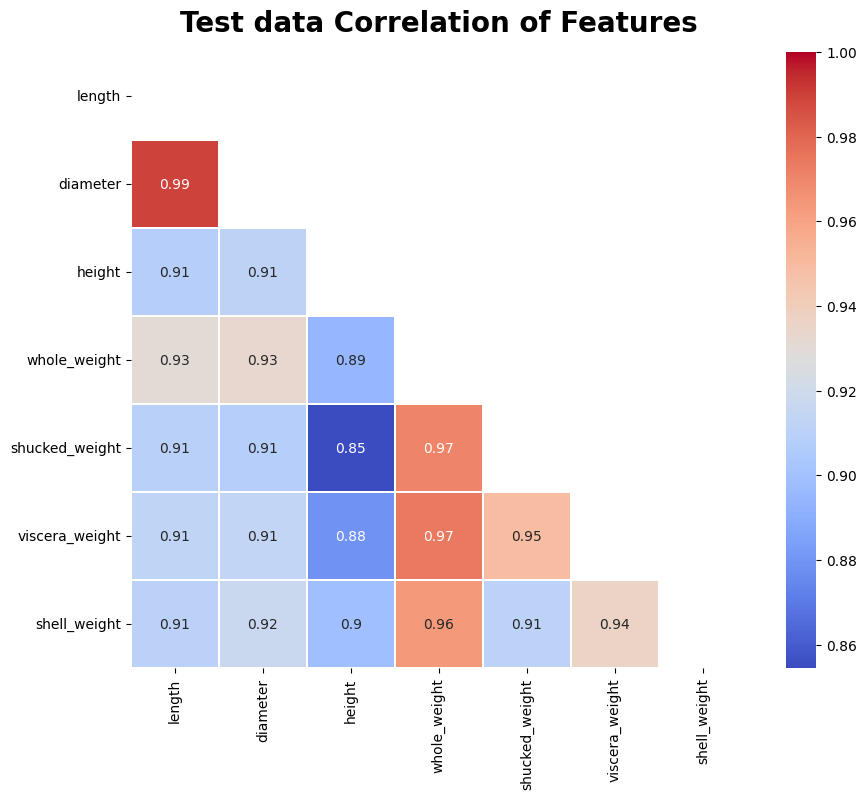

In [170]:
def plot_heatmap(df,title):
    
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize=(10, 8))
    
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)
    
    sns.heatmap(df.astype(float).corr(),
                linewidths=0.1,
                vmax=1.0, 
                square=True, 
                cmap='coolwarm', 
                linecolor='white', 
                annot=True, 
                mask=mask)
    
plot_heatmap(train[numeric_cols], title='Train data')
plot_heatmap(test[numeric_cols_without_target], title='Test data')

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>When all features are highly correlated, it can lead to multicollinearity in your model, which can make the model's estimates very sensitive to changes in the model. Here are a few strategies to handle this situation</p>

<ul>  
    <li><b>Feature Selection:</b> You can manually select a subset of your features based on domain knowledge or based on the correlation matrix</li>
    <li><b>Dimensionality Reduction:</b> Techniques like Principal Component Analysis (PCA) can be used to reduce the dimensionality of your data. PCA creates new uncorrelated variables that successively maximize variance</li>
    <li><b>Regularization:</b> Use a model that includes a penalty term for complexity in the loss function, such as Lasso or Ridge regression. These models can help to avoid overfitting by penalizing large coefficients</li>
    <li><b>Variance Inflation Factor (VIF):</b> Calculate the VIF for each variable, which measures how much the variance of the estimated regression coefficients are increased because of multicollinearity. If VIF is high for a variable, consider dropping it</li>
    <li><b>Combine Features:</b> If it makes sense in the context of your problem, you can combine correlated features into a single feature (for example, by taking an average)</li>
</ul>

</div>

### Hierarchical Clustering

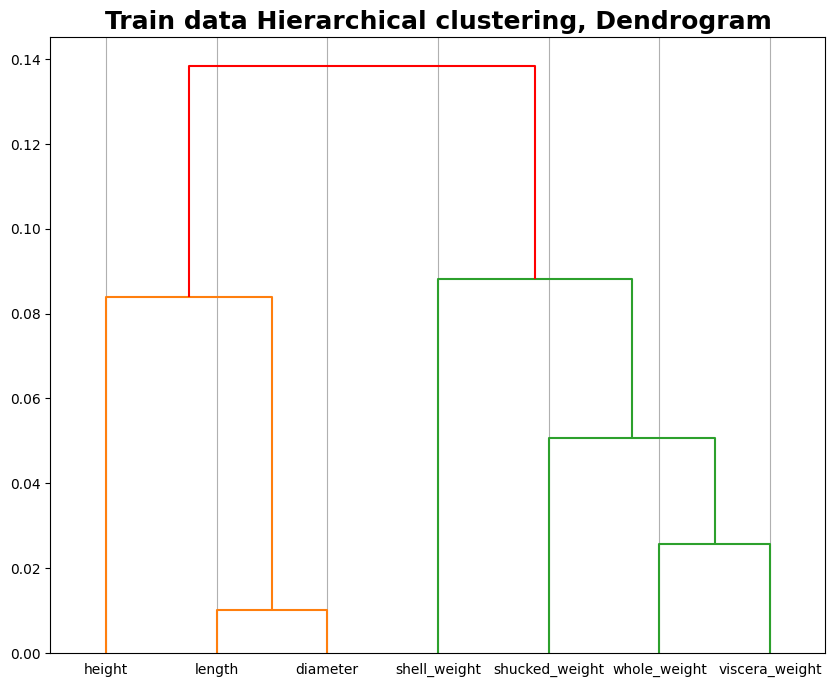

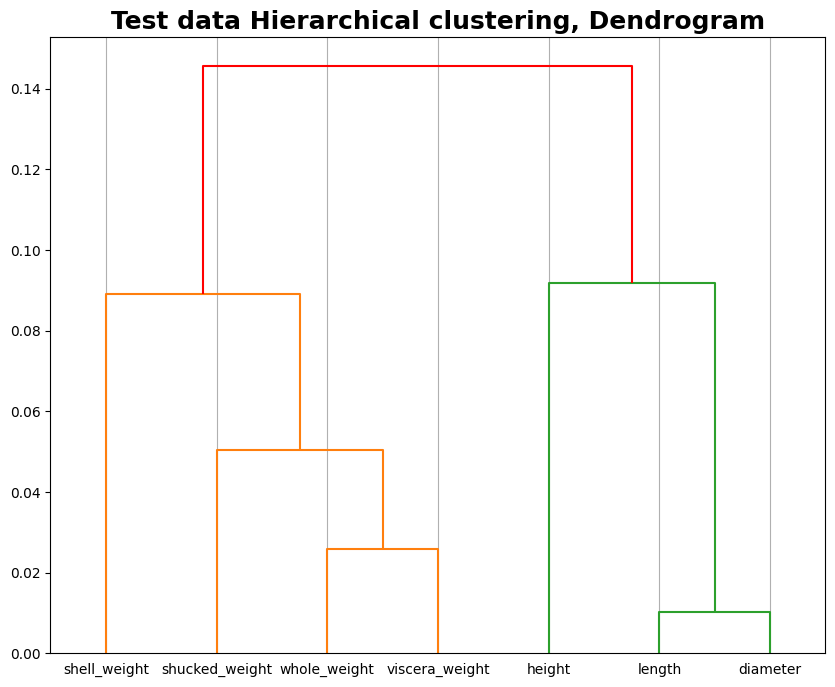

In [171]:
def hierarchical_clustering(data, title, drop_cols=[]):
    
    data = data.drop(drop_cols, axis=1, errors='ignore')
    
    fig, axis = plt.subplots(1,1,figsize=(10, 8),dpi=100)
    correlations = data.corr()
    coverted_corr = 1 - np.abs(correlations)
    Z = linkage(squareform(coverted_corr), method='complete')
    
    dn = dendrogram(Z, labels=data.columns, ax=axis, above_threshold_color='#ff0000', leaf_font_size=10) 
    hierarchy.set_link_color_palette(None)
    plt.grid(axis='x')
    plt.title(f'{title} Hierarchical clustering, Dendrogram', fontsize=18, fontweight='bold')
    plt.show()
    
hierarchical_clustering(train[numeric_cols], title='Train data', drop_cols='rings')
hierarchical_clustering(test[numeric_cols_without_target], title='Test data')

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>A dendrogram is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering. The main use of a dendrogram is to work out the best way to allocate objects to clusters</p>

<p>Observations are allocated to clusters by drawing a horizontal line through the dendrogram. Observations that are joined together below the line are in clusters</p>

<p>In the case, seems we have two clusters</p>
<ul>
    <li><b>weight cluster</b> -> shell + schuked + whole + viscera</li>
    <li><b>dimensions cluster</b> -> height + lenght + diameter</li>
<ul>

</div>

###  QQplots

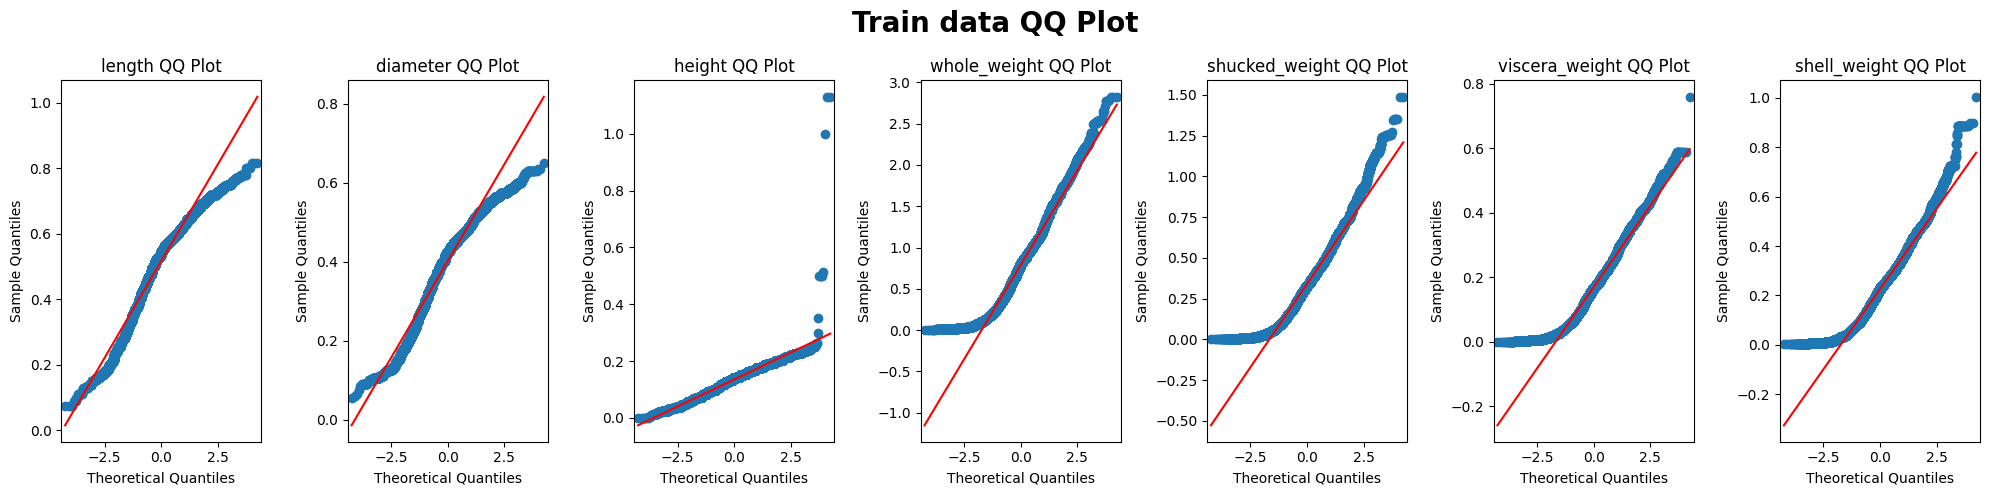

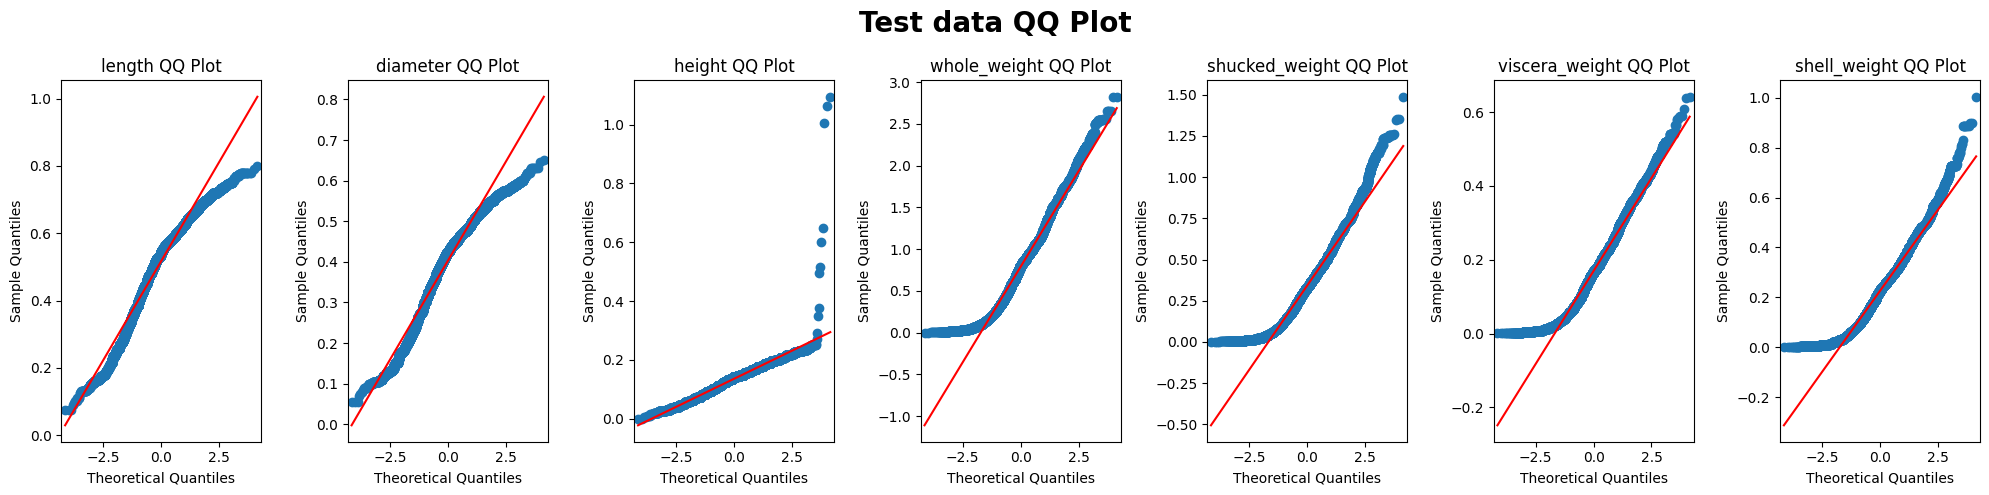

In [172]:
def plot_qqplot(df, title, drop_cols=[]):
    
    df = df.drop(drop_cols, axis=1, errors='ignore')
    
    fig, axes = plt.subplots(1, len(df.columns), figsize=(20, 5))
    
    for i, col in enumerate(df.columns):
        qqplot(df[col], line='s', ax=axes[i])
        axes[i].set_title(f'{col} QQ Plot')
    
    fig.suptitle(f'{title} QQ Plot', fontweight='bold', fontsize=20)
    plt.tight_layout()
    plt.show()
    
plot_qqplot(train[numeric_cols], title='Train data', drop_cols='rings')
plot_qqplot(test[numeric_cols_without_target], title='Test data')

### Normality check

In [173]:
def normality_test(data, alpha=0.05):
    stat = None
    for col in data.columns:
        _, p = normaltest(data[col].dropna())
        if p > alpha:
            print(f'{col} is normally distributed')
        else:
            print(f'{col} is not normally distributed')

                
normality_test(train[numeric_cols])
normality_test(test[numeric_cols_without_target])

length is not normally distributed
diameter is not normally distributed
height is not normally distributed
whole_weight is not normally distributed
shucked_weight is not normally distributed
viscera_weight is not normally distributed
shell_weight is not normally distributed
rings is not normally distributed
length is not normally distributed
diameter is not normally distributed
height is not normally distributed
whole_weight is not normally distributed
shucked_weight is not normally distributed
viscera_weight is not normally distributed
shell_weight is not normally distributed


<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>If the distribution of your data is not normal, there are several strategies you can use to transform your data to be more normally distributed:</p>
<div>
<ul>
<li><b>Log Transformation:</b> This is useful when your data is skewed. It can help to reduce the skewness.</li>
<pre>
<code>
df['log_transformed'] = np.log(df['original_column'] + 1)
</code>
</pre>
<li><b>Square Root Transformation:</b> This is another method to reduce skewness. It's less strong than the log transformation.</li>
<pre>
<code>
df['sqrt_transformed'] = np.sqrt(df['original_column'])
</code>
</pre>


<li><b>Box-Cox Transformation:</b> This is a parametric transformation method that seeks the best power transformation of the data that reduces skewness.</li>
<pre>
<code>
df['boxcox_transformed'], _ = stats.boxcox(df['original_column'] + 1)
</code>
</pre>

<li><b>Yeo-Johnson Transformation:</b> This is similar to Box-Cox, but it can be used with zero and negative values.</li>
<pre>
<code>
df['yeojohnson_transformed'], _ = stats.yeojohnson(df['original_column'])
</code>
</pre>
<ul>
</div>
<p>Remember to add 1 to your data (df['original_column'] + 1) before applying log or Box-Cox transformation to handle zero values.</p>

<p>After applying these transformations, you can check the normality of your data again. If it's still not normal, you might need to use non-parametric statistical methods that do not assume a normal distribution.</p>

</div>

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_15748\3678443125.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=train,x='sex', y=train['rings'],palette='coolwarm');


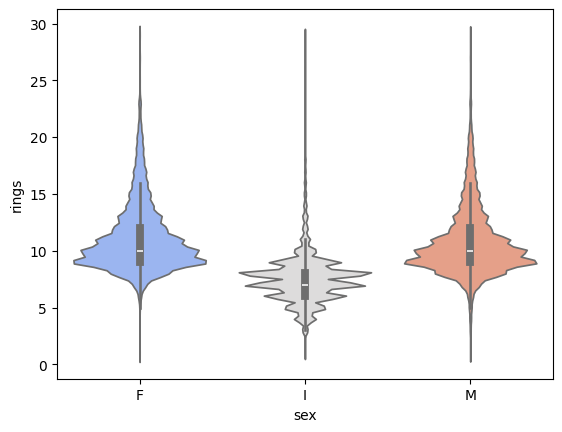

In [174]:
# Violinplot sex and rings by sex
sns.violinplot(data=train,x='sex', y=train['rings'],palette='coolwarm');

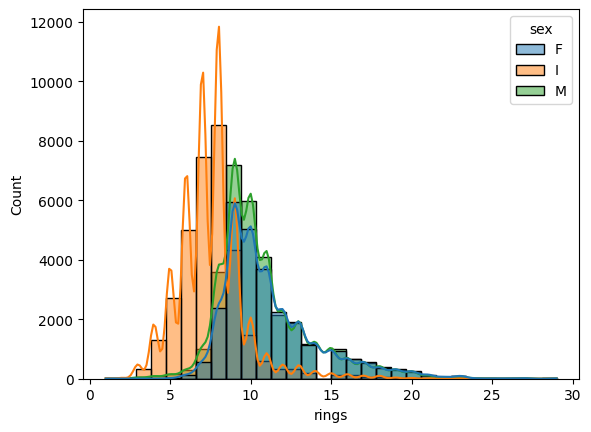

In [175]:
# checking the distribution of the target variable
sns.histplot(data=train, x='rings', hue='sex',kde=True, bins=30);

## 1.3 - Bivariate Analysis

### PairPlot

In [176]:
#sns.pairplot(data=train, vars=numeric_cols, hue='sex', diag_kind='kde', corner=True);

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

<p>Inferences</p>

<ol>
<li>There is a bit diference between an infant and adult Abalone</li>
<li>
<p>Linear relations:</p>
<ul>length vs diameter - (+++)  - </ul>
<ul>height vs length and diameter - (+) </ul>
<ul>between weights - (+++) with dispersion </ul>
<li>
<p>Polinomial relations</p>
<ul>all weights vs length - poly2, exp</ul>
<ul>all weights vs diameter - pol2, exp </ul>
</li>
<li>Sex is an important feature to destinguist between infant and adult</li>
<ol>

<div>

- Sex: This feature represents the gender of the abalone,categorized as male (M), female (F), or infant (I).

- Length: The length feature denotes the longest measurement of the abalone shell, from the apex to the base, measured in millimeters.

- Diameter: Diameter represents the measurement of the abalone shell perpendicular to its length, also measured in millimeters.

- Height: This feature signifies the height of the abalone shell, measured perpendicular to the plane formed by the length and diameter, in millimeters.

- Whole weight: Whole weight indicates the total weight of the abalone, encompassing both the meat and the shell, measured in grams.

- Whole weight.1 (Shucked weight): This feature represents the weight of the abalone meat only, measured in grams. It indicates the amount of meat extracted from the shell.

- Whole weight.2 (Viscera weight): Viscera weight signifies the weight of the abalone gut after bleeding, measured in grams.It provides insights into the weight of the internal organs of the abalone.

- Shell weight: This feature represents the weight of the abalone shell only, excluding the meat, measured in grams. It provides insights into the weight distribution between the shell and the edible portion of the abalone.

- Rings: Rings signify the number of rings present on the abalone shell, serving as an indicator of the abalone's age.

In [177]:
# rules data need to respect
# whole weight >= shucked weight + viscera weight + shell weight

df_test = train.copy()

df_test['weight_check_shucked'] = df_test['whole_weight'] > df_test['shucked_weight']
df_test['weight_check_viscera'] = df_test['whole_weight'] > df_test['viscera_weight']
df_test['weight_check_shell'] = df_test['whole_weight'] > df_test['shell_weight']

In [178]:
# check if there are any rows fail to respect the rules
df_test_error1 = df_test[df_test['weight_check_shucked'] == False]
df_test_error2 = df_test[df_test['weight_check_viscera'] == False]
df_test_error3 = df_test[df_test['weight_check_shell'] == False]

df_test_error1.shape[0], df_test_error2.shape[0], df_test_error3.shape[0]

(43, 4, 10)

In [179]:
# id of row that fail to respect the rules
df_test_error1.index, df_test_error2.index, df_test_error3.index

(Index([   30,   963,  3077,  3234,  6556,  6885,  7526,  7816, 12197, 14962,
        15485, 16334, 18675, 21531, 25099, 25631, 28050, 34642, 38365, 45011,
        46344, 46783, 47722, 47778, 48288, 48405, 48966, 50670, 50701, 51885,
        53673, 55981, 61854, 62151, 66208, 66743, 67291, 72349, 74344, 76905,
        77702, 81002, 87663],
       dtype='int64', name='id'),
 Index([25631, 50169, 50670, 51885], dtype='int64', name='id'),
 Index([7025, 16434, 18326, 47722, 50169, 50670, 52324, 64652, 70819, 84238], dtype='int64', name='id'))

In [180]:
# do they have id in common ?
set(df_test_error1.index) & set(df_test_error2.index) & set(df_test_error3.index)

{50670}

In [181]:
# total number of rows that fail to respect the rules
df_test_error1.shape[0] + df_test_error2.shape[0] + df_test_error3.shape[0]

57

In [182]:
# check if test data respect the rules
df_test_test = test.copy()

df_test_test['weight_check_shucked'] = df_test_test['whole_weight'] > df_test_test['shucked_weight']
df_test_test['weight_check_viscera'] = df_test_test['whole_weight'] > df_test_test['viscera_weight']
df_test_test['weight_check_shell'] = df_test_test['whole_weight'] > df_test_test['shell_weight']

# check if there are any rows fail to respect the rules
df_test_error1_test = df_test_test[df_test_test['weight_check_shucked'] == False]
df_test_error2_test = df_test_test[df_test_test['weight_check_viscera'] == False]
df_test_error3_test = df_test_test[df_test_test['weight_check_shell'] == False]

df_test_error1_test.shape[0], df_test_error2_test.shape[0], df_test_error3_test.shape[0]

df_test_error1_test.index, df_test_error2_test.index, df_test_error3_test.index

set(df_test_error1_test.index) & set(df_test_error2_test.index) & set(df_test_error3_test.index)

df_test_error1_test.shape[0] + df_test_error2_test.shape[0] + df_test_error3_test.shape[0]

51

In [183]:
df_test_error1_test.shape[0], df_test_error2_test.shape[0], df_test_error3_test.shape[0]

(40, 2, 9)

In [184]:
# index for df_test_error1_test
index_weight_check_shucked = df_test_error1_test.index
index_weight_check_viscera = df_test_error2_test.index
index_weight_check_shell = df_test_error3_test.index

print(index_weight_check_shucked)
print(index_weight_check_viscera)
print(index_weight_check_shell)

# What are the  5 similar neighbors of each index_height_0 ?
index_height_0 = train[train['height'] == 0].index
print(index_height_0)

Index([ 92753,  93565,  95726,  95771,  98505,  99117, 101167, 104514, 104946,
       105312, 106867, 108956, 109874, 110505, 110891, 111636, 112306, 112702,
       113290, 115943, 116214, 120044, 120787, 121267, 121389, 122747, 124729,
       125832, 126455, 131118, 133443, 135049, 138437, 141050, 141727, 143395,
       143461, 145701, 146136, 148788],
      dtype='int64', name='id')
Index([110891, 116214], dtype='int64', name='id')
Index([98313, 104117, 110891, 114558, 117138, 123574, 134791, 138437, 141893], dtype='int64', name='id')
Index([7025, 14208, 32078, 52324, 70295, 90295], dtype='int64', name='id')


In [185]:
# get the 5 similar neighbors of each index_height_0[0]
def get_similar_neighbors(df, index, n_neighbors=5):

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(df_scaled)
    _, indices = knn.kneighbors(df_scaled)
    return indices[index]

def impute_knn(df, indexes, col, n_neighbors=7):
    
    df = df.copy()
    
    saved_indexes_values = {}
    
    for index in indexes:
        print(f'for index: {index} in column: {col}')
        similar_neighbors = get_similar_neighbors(df[numeric_cols], index, n_neighbors)
        
        print(f'\tThe Similar neighbors are at indexes: {similar_neighbors}')
        
        value_mean = df.iloc[similar_neighbors][col].mean().round(3)
        print(f'\tThe imputed mean value will be: {value_mean}\n')
        
        saved_indexes_values[index] = value_mean
        
    # impute the values to the dataframe
    for index, value in saved_indexes_values.items():
        df.loc[index, 'height'] = value

    return df

In [186]:
df_transformed = impute_knn(train, index_height_0, col='height', n_neighbors=7)

df_transformed.loc[index_height_0]

for index: 7025 in column: height


	The Similar neighbors are at indexes: [ 7025 52324 18326 64652 70819 84238 90295]
	The imputed mean value will be: 0.04

for index: 14208 in column: height
	The Similar neighbors are at indexes: [14208 70295 90295 32078 88891 54908  6037]
	The imputed mean value will be: 0.028

for index: 32078 in column: height
	The Similar neighbors are at indexes: [32078 70295 14208 90295 60035 88891 17288]
	The imputed mean value will be: 0.031

for index: 52324 in column: height
	The Similar neighbors are at indexes: [52324  7025 18326 64652 70819 70295 14208]
	The imputed mean value will be: 0.029

for index: 70295 in column: height
	The Similar neighbors are at indexes: [70295 14208 32078 90295 88891 54908  6037]
	The imputed mean value will be: 0.028

for index: 90295 in column: height
	The Similar neighbors are at indexes: [90295 14208 70295 32078 29486 22441 46058]
	The imputed mean value will be: 0.024



,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
id,,,,,,,,,
7025,I,0.315,0.230,0.040,0.1340,0.0545,0.0245,0.3505,8
14208,I,0.430,0.340,0.028,0.3440,0.1880,0.0705,0.1050,8
32078,M,0.470,0.355,0.031,0.5785,0.2965,0.1550,0.1360,7
52324,I,0.315,0.230,0.029,0.1340,0.0530,0.0375,0.3505,7
70295,I,0.430,0.340,0.028,0.4060,0.2035,0.0960,0.1230,7
90295,M,0.430,0.325,0.024,0.3335,0.1350,0.0585,0.1050,10


In [189]:
df_transformed

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...
90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6


In [ ]:
#index_weight_check_shucked = df_test_error1_test.index
#index_weight_check_viscera = df_test_error2_test.index
#index_weight_check_shell = df_test_error3_test.index

In [193]:
index_weight_check_shucked

Index([ 92753,  93565,  95726,  95771,  98505,  99117, 101167, 104514, 104946,
       105312, 106867, 108956, 109874, 110505, 110891, 111636, 112306, 112702,
       113290, 115943, 116214, 120044, 120787, 121267, 121389, 122747, 124729,
       125832, 126455, 131118, 133443, 135049, 138437, 141050, 141727, 143395,
       143461, 145701, 146136, 148788],
      dtype='int64', name='id')

In [199]:
# Need to clean weight_check_shucked, weight_check_viscera, weight_check_shell

# 2 - Feature Engineering